In [1]:
import torch
import matplotlib.pyplot as plt

In [ ]:
D = 3  # 2-sphere
K = 1  # 1-dimensional manifold
L = 5  # Uniform[-L, L] distribution
B = 4_096  # sampling batch size

In [3]:
source_dist = torch.distributions.uniform.Uniform(-L, L)
target_dist = torch.distributions.normal.Normal(0, 1)

Let's visualize the target distribution samples $\sim \mathcal{U}(S^{D - 1})$.

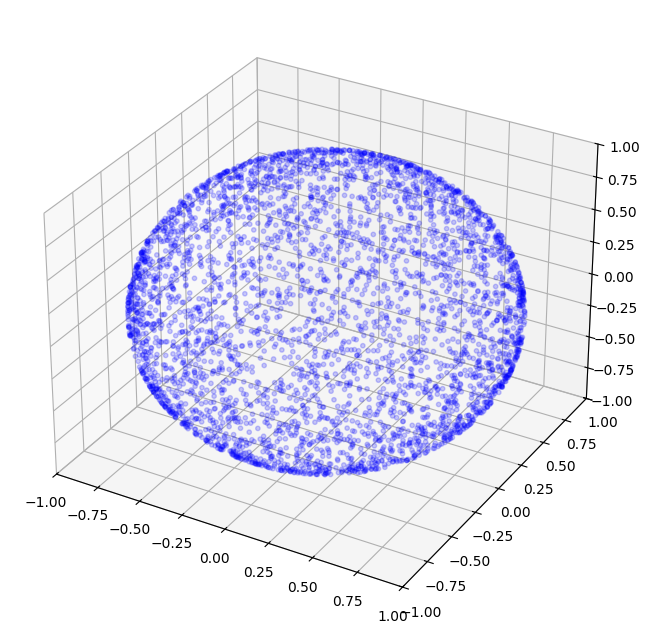

In [4]:
target_test = torch.nn.functional.normalize(target_dist.sample((B, D)), p=2).numpy()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(target_test[:, 0], target_test[:, 1], target_test[:, 2], c='blue', alpha=0.2, s=10)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

## $\phi$ : Vanilla Generative Adversarial Framework

In [ ]:
class Phi(torch.nn.Module):
    def __init__(self, omega=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(K, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, D)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return torch.nn.functional.normalize(X, p=2)

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self, omega=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omega = omega
        self.fc1 = torch.nn.Linear(D, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.fc4 = torch.nn.Linear(256, 1)

    def forward(self, X):
        X = self.fc1(X)
        X = torch.sin(30 * X)
        X = self.fc2(X)
        X = torch.sin(self.omega * X)
        X = self.fc3(X)
        X = torch.sin(self.omega * X)
        X = self.fc4(X)
        return X

In [7]:
LR = 1e-4
EPOCHS = 250
D_ITERATIONS = 10
G_ITERATIONS = 5

In [25]:
generator = Phi().to('cuda')
critic = Discriminator().to('cuda')

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=LR)
criterion = torch.nn.BCEWithLogitsLoss()

In [26]:
source_samples = source_dist.sample((B, K)).to('cuda')
target_samples = torch.nn.functional.normalize(target_dist.sample((B, D)), p=2).to('cuda')

one_labels = torch.ones(B, 1).to('cuda')
zero_labels = torch.zeros(B, 1).to('cuda')

In [27]:
for epoch in range(EPOCHS):
    for _ in range(D_ITERATIONS):
        target_fwd = critic(target_samples)
        target_err = criterion(target_fwd, one_labels)
        
        phi = generator(source_samples)
        source_fwd = critic(phi)
        source_err = criterion(source_fwd, zero_labels)

        critic_loss = target_err + source_err
        critic_loss.backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()
    for _ in range(G_ITERATIONS):
        phi = generator(source_samples)
        source_fwd = critic(phi)
        gen_loss = criterion(source_fwd, one_labels)
        
        gen_loss.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

    print(f"Epoch {epoch + 1} | Critic Loss: {critic_loss.item():.5f} | Phi Loss: {gen_loss.item():.5f}")

Epoch 1 | Critic Loss: 1.33049 | Phi Loss: 0.71275
Epoch 2 | Critic Loss: 1.37078 | Phi Loss: 0.70456
Epoch 3 | Critic Loss: 1.36330 | Phi Loss: 0.71315
Epoch 4 | Critic Loss: 1.34518 | Phi Loss: 0.70028
Epoch 5 | Critic Loss: 1.34299 | Phi Loss: 0.69880
Epoch 6 | Critic Loss: 1.33751 | Phi Loss: 0.70868
Epoch 7 | Critic Loss: 1.31149 | Phi Loss: 0.71278
Epoch 8 | Critic Loss: 1.30059 | Phi Loss: 0.72531
Epoch 9 | Critic Loss: 1.27038 | Phi Loss: 0.73358
Epoch 10 | Critic Loss: 1.25650 | Phi Loss: 0.74702
Epoch 11 | Critic Loss: 1.22561 | Phi Loss: 0.73017
Epoch 12 | Critic Loss: 1.24383 | Phi Loss: 0.73769
Epoch 13 | Critic Loss: 1.20559 | Phi Loss: 0.74284
Epoch 14 | Critic Loss: 1.19826 | Phi Loss: 0.75228
Epoch 15 | Critic Loss: 1.17659 | Phi Loss: 0.75892
Epoch 16 | Critic Loss: 1.16022 | Phi Loss: 0.77450
Epoch 17 | Critic Loss: 1.14747 | Phi Loss: 0.77620
Epoch 18 | Critic Loss: 1.14100 | Phi Loss: 0.77188
Epoch 19 | Critic Loss: 1.13758 | Phi Loss: 0.78184
Epoch 20 | Critic Los

We see that a vanilla GAN for $\phi : \mathcal{U}[-L, L] \rightarrow \mathcal{U}(S^{d-1})$ *can* work for a trivial problem like $d = 3$.

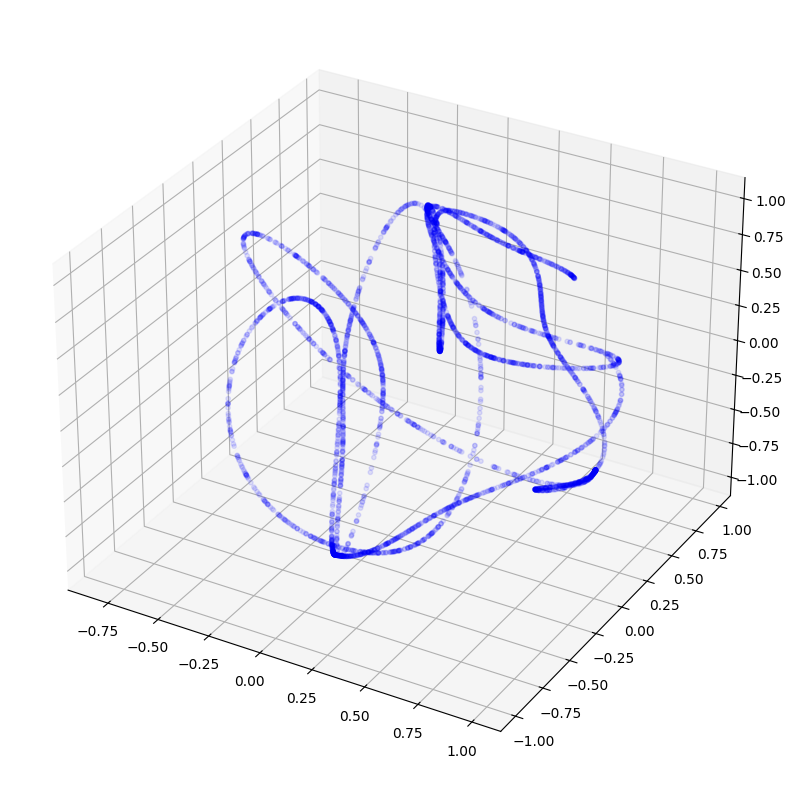

In [42]:
data = source_dist.sample((4096, K)).to('cuda')
manifold = generator(data).cpu().detach()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold.numpy()[:, 0], manifold.numpy()[:, 1], manifold.numpy()[:, 2], c='blue', alpha=0.1, s=10)
plt.show()

## $\phi$ : Sliced Wasserstein GAN